In [ ]:
# Imports (general)
import os
import sys
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import torch

In [ ]:
# Error Metric Functions

def compute_depth_errors(gt, pred, mask):
    """Standard KITTI / Monodepth2 errors (Abs Rel, Sq Rel, RMSE, RMSE log, δ‑<1.25^n)."""
    gt_valid = gt[mask]
    pred_valid = pred[mask]
    thresh = np.maximum(gt_valid / pred_valid, pred_valid / gt_valid)
    a1 = np.mean(thresh < 1.25)
    a2 = np.mean(thresh < 1.25 ** 2)
    a3 = np.mean(thresh < 1.25 ** 3)
    abs_rel = np.mean(np.abs(gt_valid - pred_valid) / gt_valid)
    sq_rel  = np.mean(((gt_valid - pred_valid) ** 2) / gt_valid)
    rmse    = np.sqrt( np.mean( (gt_valid - pred_valid) ** 2 ) )
    rmse_log= np.sqrt( np.mean( (np.log(gt_valid) - np.log(pred_valid)) ** 2 ) )
    return {
        "rmse": rmse, "abs_rel": abs_rel, "sq_rel": sq_rel,
        "rmse_log": rmse_log, "delta1": a1, "delta2": a2, "delta3": a3
    }


In [ ]:
# Eigen Crop Mask

def eigen_crop_mask(shape):
    h, w = shape[:2]
    top = 44
    bot = min(top + 352, h)
    left = 0
    right = w  # use full width
    mask = np.zeros((h, w), dtype=bool)
    mask[top:bot, left:right] = True
    return mask

In [ ]:
# Setup Model Wrappers

import torch
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# DepthPro

from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation

print("Loading DepthPro...")

checkpoint1 = "apple/DepthPro-hf"
proc1 = DepthProImageProcessorFast.from_pretrained(checkpoint1)
mdl1 = DepthProForDepthEstimation.from_pretrained(checkpoint1).to(DEVICE).eval()

# Define the function to run inference with the model
def run_mde_model_1(im_np):
    im = Image.fromarray(im_np)
    inputs = proc1(images=im, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outs = mdl1(**inputs)
    post = proc1.post_process_depth_estimation(outs, target_sizes=[im_np.shape[:2]])[0]
    return post["predicted_depth"].cpu().numpy()

print("DepthPro loaded.")

Loading DepthPro...
DepthPro loaded.


In [ ]:
# UniDepthV2 (ViTL14)

# Import the model class from your local cloned repository
from unidepth.models import UniDepthV2

print("Loading UniDepthV2...")

# Load the pretrained model using the name from the Model Zoo
ud_mdl = UniDepthV2.from_pretrained("/home/arkadiptasarkar/MDE_project_wsl/pretrained_wt").to(DEVICE).eval()
#ud_mdl = UniDepthV2.from_pretrained(r"C:\Users\arkad\Downloads\pretrained_wt").to(DEVICE).eval()

# Define the function to run inference with the model
def run_mde_model_2(im_np):
    
    # The model handles its own normalization
    rgb_torch = torch.from_numpy(im_np).permute(2, 0, 1).to(DEVICE) # C, H, W 

    with torch.no_grad():
        # Use the model's infer method as shown in the documentation 
        predictions = ud_mdl.infer(rgb_torch)
        depth = predictions["depth"] # The output is already a tensor

    # The output from infer() is on the correct device, just needs to be squeezed and moved to cpu
    return depth.squeeze().cpu().numpy()

print("UniDepthV2 loaded.")

/home/arkadiptasarkar/MDE_project_wsl/UniDepth/unidepth/layers/nystrom_attention.py:9: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import NystromAttention


Cannot import NystromAttention, you can not run original UniDepth. UniDepthV2 is available.
Loading UniDepthV2...


/home/arkadiptasarkar/MDE_project_wsl/UniDepth/unidepth/models/backbones/dinov2.py:481: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained, map

loading from /home/arkadiptasarkar/MDE_project_wsl/pretrained_wt/dinov2_vitl14_pretrain.pth with: _IncompatibleKeys(missing_keys=['register_tokens'], unexpected_keys=[])
Loading weights from local directory
UniDepthV2 loaded.


In [ ]:
# Mask2Former for Vehicle Segmentation

import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import matplotlib.pyplot as plt

# Load the image processor and the model from Hugging Face Hub
print("Loading Mask2Former...")
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic", use_fast = True)
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-coco-panoptic", 
    use_safetensors=True
).to(DEVICE)
# Define the function for individual vehicle segmentation
def individual_vehicle_segmentation(im_np):
    """Segment individual vehicles in an image using Mask2Former."""
    
    # Convert the input numpy array to a PIL image
    image = Image.fromarray(im_np)

    # Process the Image and Perform Inference
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the Output to get Panoptic Segments
    result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    panoptic_map = result['segmentation'].cpu().numpy()
    segments_info = result['segments_info']

    # Filter for 'car' segments and extract individual masks
    car_masks = []
    car_label_id = -1

    for i, label_name in model.config.id2label.items():
        if label_name == 'car':
            car_label_id = i
            break

    if car_label_id == -1:
        print("Could not find 'car' label in the model's configuration.")
        return []

    
    for segment in segments_info:
        if segment['label_id'] == car_label_id:
            segment_id = segment['id']
            mask = (panoptic_map == segment_id)
            car_masks.append({
                "mask": mask,
                "score": segment['score'],
                "id": segment_id
            })
    
    return car_masks

print("Mask2Former loaded & Individual vehicle segmentation completed.")

Loading Mask2Former...
Mask2Former loaded & Individual vehicle segmentation completed.


In [ ]:
# Path Discovery for Nested KITTI Eigen Dataset

# Path to your dataset root
root_path = r"/mnt/c/Users/arkad/OneDrive/Desktop/Thesis work/kitti eigen split dataset"
test_root = os.path.join(root_path, "train")

min_depth = 1e-3
max_depth = 80.0

# Recursively find all ground-truth depth files
gt_pngs = glob.glob(os.path.join(test_root, "*", "*_sync", "proj_depth", "groundtruth", "image_02", "*.png"))

rel_list = []
for gt_path in tqdm(gt_pngs, desc="Indexing depth files"):
    # Extract components from full path
    parts = gt_path.split(os.path.sep)
    date = parts[-6]                 # e.g., '2011_09_26'
    drive = parts[-5]                # e.g., '2011_09_26_drive_0002_sync'
    filename = parts[-1]            # e.g., '0000000005.png'

    # Construct RGB path
    rgb_path = os.path.join(test_root, date, drive, "image_02", "data", filename)
    if not os.path.exists(rgb_path):
        print(f"Missing RGB image: {rgb_path}")
        continue

    rel_list.append({
        "sequence": date,
        "drive": drive,
        "filename": filename,
        "gt_path": gt_path,
        "rgb_path": rgb_path
    })

val_list = pd.DataFrame(rel_list)
print(f"Found {len(val_list)} image pairs from {val_list['drive'].nunique()} drives across {val_list['sequence'].nunique()} sequences.")


Indexing depth files:   0%|          | 0/20 [00:00<?, ?it/s]

Found 20 image pairs from 1 drives across 1 sequences.


In [ ]:
import logging

# Set the logging level for the 'transformers' library to ERROR,
# which will hide INFO and WARNING messages.
logging.getLogger("transformers").setLevel(logging.ERROR)

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import math

# --- Configuration for Angle Calculation ---
# Using a common focal length for the KITTI dataset.
# You may need to adjust this if you are using a different dataset.
FOCAL_LENGTH_X = 721.5577

# This list will store a dictionary for each detected vehicle,
# containing all data needed for analysis and visualization.
all_results_data = []

# --- Main Processing Loop ---
for index, row in tqdm(val_list.iterrows(), total=len(val_list), desc="Processing Images"):
    filename = row['filename']
    image_path = row['rgb_path']
    gt_path = row['gt_path']

    try:
        image_np = np.array(Image.open(image_path).convert("RGB"))
        gt_depth = np.array(Image.open(gt_path)).astype(np.uint16) / 256.0
        
        # Get image dimensions for angle calculation
        img_height, img_width, _ = image_np.shape
        principal_point_x = img_width / 2

        # Run MDE models once
        pred_depth_model_1 = run_mde_model_1(image_np)
        pred_depth_model_2 = run_mde_model_2(image_np)

        # Get vehicle masks once
        car_masks_info = individual_vehicle_segmentation(image_np)

        if not car_masks_info:
            continue

        # Process each detected car in the image
        for i, car_info in enumerate(car_masks_info):
            mask = car_info['mask']
            score = car_info['score']
            # Skip if the car score is too small citing inaccuracy
            if score < 0.9:
                continue
            # Create the final evaluation mask for this car
            crop_mask = eigen_crop_mask(gt_depth.shape)
            final_mask = mask & (gt_depth > min_depth) & (gt_depth < max_depth) & crop_mask

            # Calculate metrics for each model
            pred_depth_model_1 = np.clip(pred_depth_model_1, min_depth, max_depth)
            scale_1 = np.median(gt_depth[final_mask]) / np.median(pred_depth_model_1[final_mask])
            pred_depth_model_1 = np.clip(pred_depth_model_1 * scale_1, min_depth, max_depth)
            metrics_model_1 = compute_depth_errors(gt_depth, pred_depth_model_1, final_mask)

            pred_depth_model_2 = np.clip(pred_depth_model_2, min_depth, max_depth)
            scale_2 = np.median(gt_depth[final_mask]) / np.median(pred_depth_model_2[final_mask])
            pred_depth_model_2 = np.clip(pred_depth_model_2 * scale_2, min_depth, max_depth)
            metrics_model_2 = compute_depth_errors(gt_depth, pred_depth_model_2, final_mask)

            # Skip if there's no valid ground truth depth for this car
            if not np.any(final_mask):
                continue

            # Calculate horizontal angle
            y_coords, x_coords = np.where(mask)
            centroid_x = np.mean(x_coords)
            angle_rad = math.atan((centroid_x - principal_point_x) / FOCAL_LENGTH_X)
            angle_deg = math.degrees(angle_rad)

            # Store results for DepthPro
            all_results_data.append({
                'model': 'DepthPro',
                'file_name': filename,
                'car_id': i,
                'car_score': car_info['score'],
                'avg_gt_depth': np.mean(gt_depth[final_mask]),
                'avg_pred_depth': np.mean(pred_depth_model_1[final_mask]),
                'rmse': metrics_model_1['rmse'],
                'horizontal_angle': angle_deg,
                # Store images for final visualization
                'rgb_image': image_np,
                'gt_depth_map': gt_depth,
                'pred_depth_map': pred_depth_model_1,
                'car_mask': final_mask
            })

            # Store results for UniDepthV2
            all_results_data.append({
                'model': 'UniDepthV2',
                'file_name': filename,
                'car_id': i,
                'car_score': car_info['score'],
                'avg_gt_depth': np.mean(gt_depth[final_mask]),
                'avg_pred_depth': np.mean(pred_depth_model_2[final_mask]),
                'rmse': metrics_model_2['rmse'],
                'horizontal_angle': angle_deg,
                # Store images for final visualization
                'rgb_image': image_np,
                'gt_depth_map': gt_depth,
                'pred_depth_map': pred_depth_model_2,
                'car_mask': final_mask
            })

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Create the final DataFrame from the collected data
results_df = pd.DataFrame(all_results_data)

print("\nData processing complete. DataFrame created.")

Processing Images:   0%|          | 0/20 [00:00<?, ?it/s]

/home/arkadiptasarkar/MDE_project_wsl/UniDepth/unidepth/models/unidepthv2/unidepthv2.py:262: UserWarning: !! self.resolution_level not set, using default bounds !!
  warnings.warn("!! self.resolution_level not set, using default bounds !!")
/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Data processing complete. DataFrame created.


In [ ]:
# Define the output path for the CSV file
output_csv_path = "depth_evaluation_per_car_train.csv"
results_df.to_csv(output_csv_path, index=True)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1600)  # Set a wider display width for better readability

print(f"Results saved to {output_csv_path}")
print(results_df[["model", "file_name", "car_id", "car_score", "avg_gt_depth", "avg_pred_depth", "rmse", "horizontal_angle"]])

Results saved to depth_evaluation_per_car_train.csv
          model       file_name  car_id  car_score  avg_gt_depth  avg_pred_depth      rmse  horizontal_angle
0      DepthPro  0000000025.png       0   0.966937     10.346467       10.402102  0.769516        -12.621582
1    UniDepthV2  0000000025.png       0   0.966937     10.346467       10.750525  1.669555        -12.621582
2      DepthPro  0000000025.png       1   0.996949      4.065918        4.222899  1.044641        -31.330323
3    UniDepthV2  0000000025.png       1   0.996949      4.065918        4.324976  1.312994        -31.330323
4      DepthPro  0000000025.png       2   0.936859     49.574555       50.371937  2.939175          0.993529
..          ...             ...     ...        ...           ...             ...       ...               ...
301  UniDepthV2  0000000044.png       5   0.994398      4.378464        4.418295  0.333629         31.474246
302    DepthPro  0000000044.png       6   0.989080     15.755745       15.54

Displaying detailed results for 5 out of 153 detected vehicles...

--- Printing results for result: 1 ---
--- Image: 0000000025.png | Vehicle ID: 0 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)    10.35      10.35
Avg Pred Depth (m)    10.40      10.75
          RMSE (m)     0.77       1.67
   Detection Score     0.97       0.97
-------------------------------------------------------


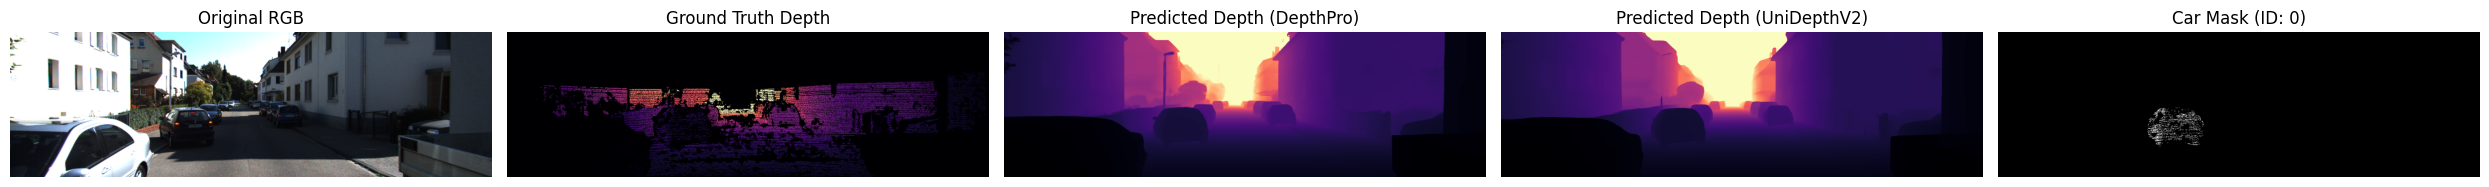



--- Printing results for result: 2 ---
--- Image: 0000000025.png | Vehicle ID: 1 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)     4.07       4.07
Avg Pred Depth (m)     4.22       4.32
          RMSE (m)     1.04       1.31
   Detection Score     1.00       1.00
-------------------------------------------------------


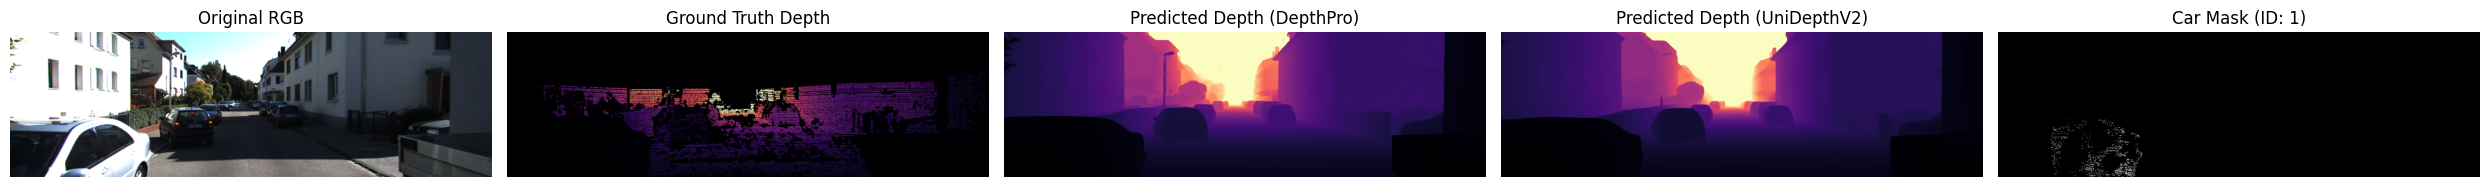



--- Printing results for result: 3 ---
--- Image: 0000000025.png | Vehicle ID: 2 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)    49.57      49.57
Avg Pred Depth (m)    50.37      51.09
          RMSE (m)     2.94       4.35
   Detection Score     0.94       0.94
-------------------------------------------------------


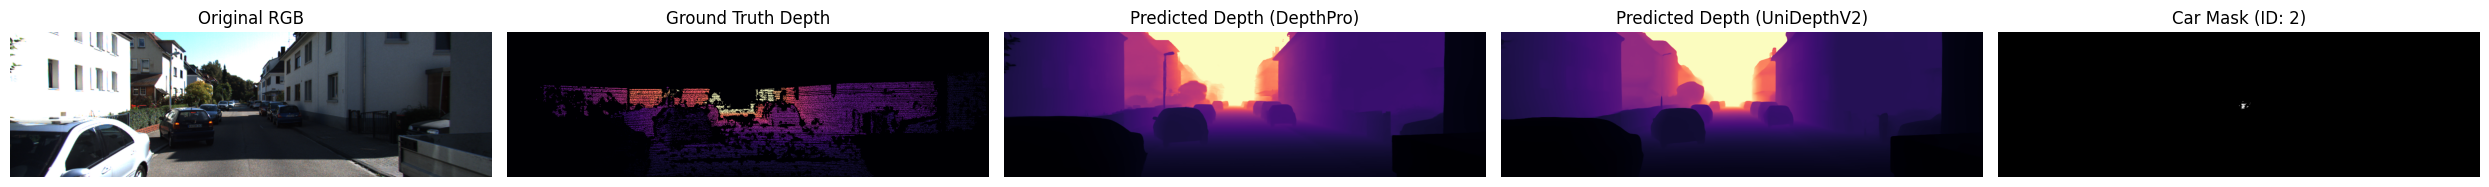



--- Printing results for result: 4 ---
--- Image: 0000000025.png | Vehicle ID: 3 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)    65.63      65.63
Avg Pred Depth (m)    65.42      65.32
          RMSE (m)     1.11       0.60
   Detection Score     0.94       0.94
-------------------------------------------------------


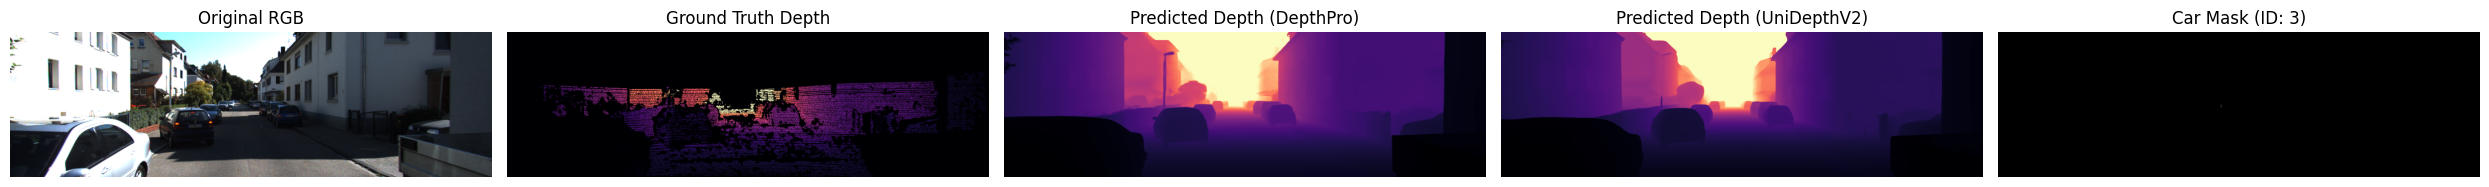



--- Printing results for result: 5 ---
--- Image: 0000000025.png | Vehicle ID: 4 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)    20.68      20.68
Avg Pred Depth (m)    20.54      20.72
          RMSE (m)     1.37       1.72
   Detection Score     0.99       0.99
-------------------------------------------------------


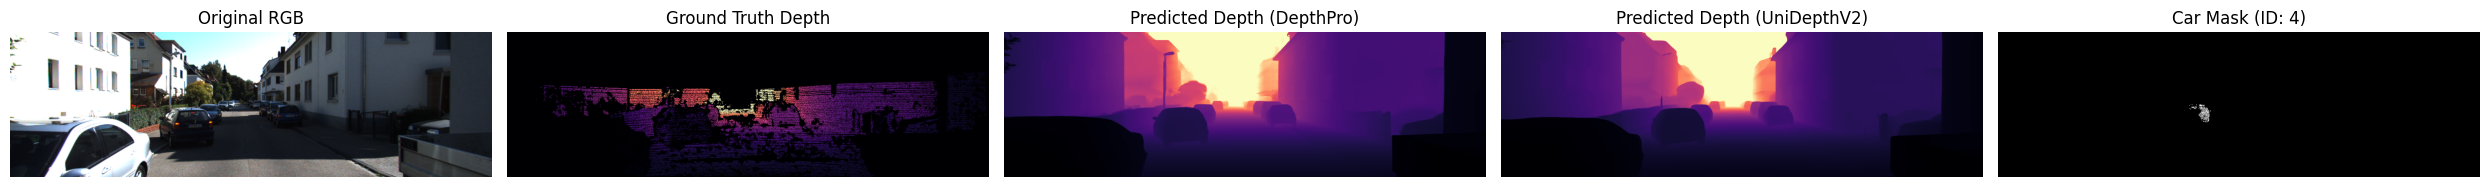



--- Printing results for result: 6 ---
--- Image: 0000000025.png | Vehicle ID: 6 ---
            Metric DepthPro UniDepthV2
  Avg GT Depth (m)    19.40      19.40
Avg Pred Depth (m)    19.17      19.67
          RMSE (m)     1.10       1.17
   Detection Score     0.97       0.97
-------------------------------------------------------


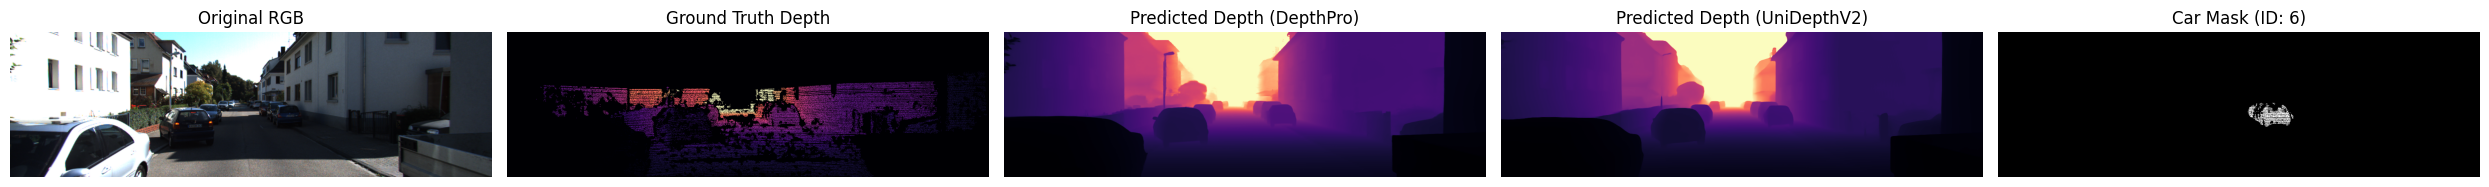

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Helper function to normalize depth maps for clear visualization
def normalize_depth_for_display(depth, cmap=plt.cm.magma):
    valid_mask = depth > 0
    vmin = np.percentile(depth[valid_mask], 2) if np.any(valid_mask) else 0
    vmax = np.percentile(depth[valid_mask], 98) if np.any(valid_mask) else 1
    normalized_depth = np.clip((depth - vmin) / (vmax - vmin), 0, 1)
    colored_depth = (cmap(normalized_depth) * 255).astype(np.uint8)
    return colored_depth

# --- Efficient Visualization Loop ---

# Group data by image and car ID to process each unique car instance
# We'll use the combined data stored in our main 'results_df'
processed_cars = results_df.groupby(['file_name', 'car_id'])
x = 5
print(f"Displaying detailed results for {x} out of {len(processed_cars)} detected vehicles...\n")
i = 0
for (filename, car_id), group in processed_cars:
    if i > x:
        break
    else:
        i += 1
    print(f"--- Printing results for result: {i} ---")
    print(f"--- Image: {filename} | Vehicle ID: {car_id} ---")
    
    # Extract data for each model from the group
    depthpro_row = group[group['model'] == 'DepthPro'].iloc[0]
    unidepth_row = group[group['model'] == 'UniDepthV2'].iloc[0]

    # Display the results in a structured format, including car score
    stats_data = {
        "Metric": ["Avg GT Depth (m)", "Avg Pred Depth (m)", "RMSE (m)", "Detection Score"],
        "DepthPro": [
            f"{depthpro_row['avg_gt_depth']:.2f}",
            f"{depthpro_row['avg_pred_depth']:.2f}",
            f"{depthpro_row['rmse']:.2f}",
            f"{depthpro_row['car_score']:.2f}"
        ],
        "UniDepthV2": [
            f"{unidepth_row['avg_gt_depth']:.2f}",
            f"{unidepth_row['avg_pred_depth']:.2f}",
            f"{unidepth_row['rmse']:.2f}",
            f"{unidepth_row['car_score']:.2f}"
        ]
    }
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_string(index=False))
    print("-" * 55)

    # --- Visualize the images (already in memory) ---
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    # Original Image (get from either row, it's the same)
    axes[0].imshow(depthpro_row['rgb_image'])
    axes[0].set_title("Original RGB")
    axes[0].axis('off')

    # Ground Truth Depth
    axes[1].imshow(normalize_depth_for_display(depthpro_row['gt_depth_map']))
    axes[1].set_title("Ground Truth Depth")
    axes[1].axis('off')

    # Predicted Depth (DepthPro)
    axes[2].imshow(normalize_depth_for_display(depthpro_row['pred_depth_map']))
    axes[2].set_title("Predicted Depth (DepthPro)")
    axes[2].axis('off')
    
    # Predicted Depth (UniDepthV2)
    axes[3].imshow(normalize_depth_for_display(unidepth_row['pred_depth_map']))
    axes[3].set_title("Predicted Depth (UniDepthV2)")
    axes[3].axis('off')
    
    # Car Mask
    axes[4].imshow(depthpro_row['car_mask'], cmap='gray')
    axes[4].set_title(f"Car Mask (ID: {car_id})")
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\n" + "="*55 + "\n")

In [ ]:
# Imports (general)
import os
import sys
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import torch

# Load the data from the CSV file
results_df = pd.read_csv('depth_evaluation_per_car_train.csv')

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1600)  # Set a wider display width for better readability

# Print the csv file
print(results_df[["model", "file_name", "car_id", "car_score", "avg_gt_depth", "avg_pred_depth", "rmse", "horizontal_angle"]])

          model       file_name  car_id  car_score  avg_gt_depth  avg_pred_depth      rmse  horizontal_angle
0      DepthPro  0000000025.png       0   0.966937     10.346467       10.402102  0.769516        -12.621582
1    UniDepthV2  0000000025.png       0   0.966937     10.346467       10.750525  1.669555        -12.621582
2      DepthPro  0000000025.png       1   0.996949      4.065918        4.222899  1.044641        -31.330323
3    UniDepthV2  0000000025.png       1   0.996949      4.065918        4.324976  1.312994        -31.330323
4      DepthPro  0000000025.png       2   0.936859     49.574555       50.371937  2.939175          0.993529
..          ...             ...     ...        ...           ...             ...       ...               ...
487  UniDepthV2  0000000024.png       4   0.975626     20.768954       21.048119  1.441991          6.406684
488    DepthPro  0000000024.png       5   0.970512     22.085655       21.864581  2.516234         -7.279293
489  UniDepthV2  00

In [ ]:
# --- Calculate and Print Average RMSE per Model ---

# Group by model, calculate the mean RMSE, and convert to a DataFrame
average_rmse_df = results_df.groupby('model')['rmse'].mean().reset_index()

# Rename columns for clarity
average_rmse_df.columns = ['Model', 'Avg RMSE (m)']


print("Average RMSE per Model:")
print("-" * 35)
# Print the DataFrame using to_string() for clean formatting without the index
print(average_rmse_df.to_string(index=False))
print("-" * 35)

Average RMSE per Model:
-----------------------------------
     Model  Avg RMSE (m)
  DepthPro      2.039471
UniDepthV2      2.543722
-----------------------------------


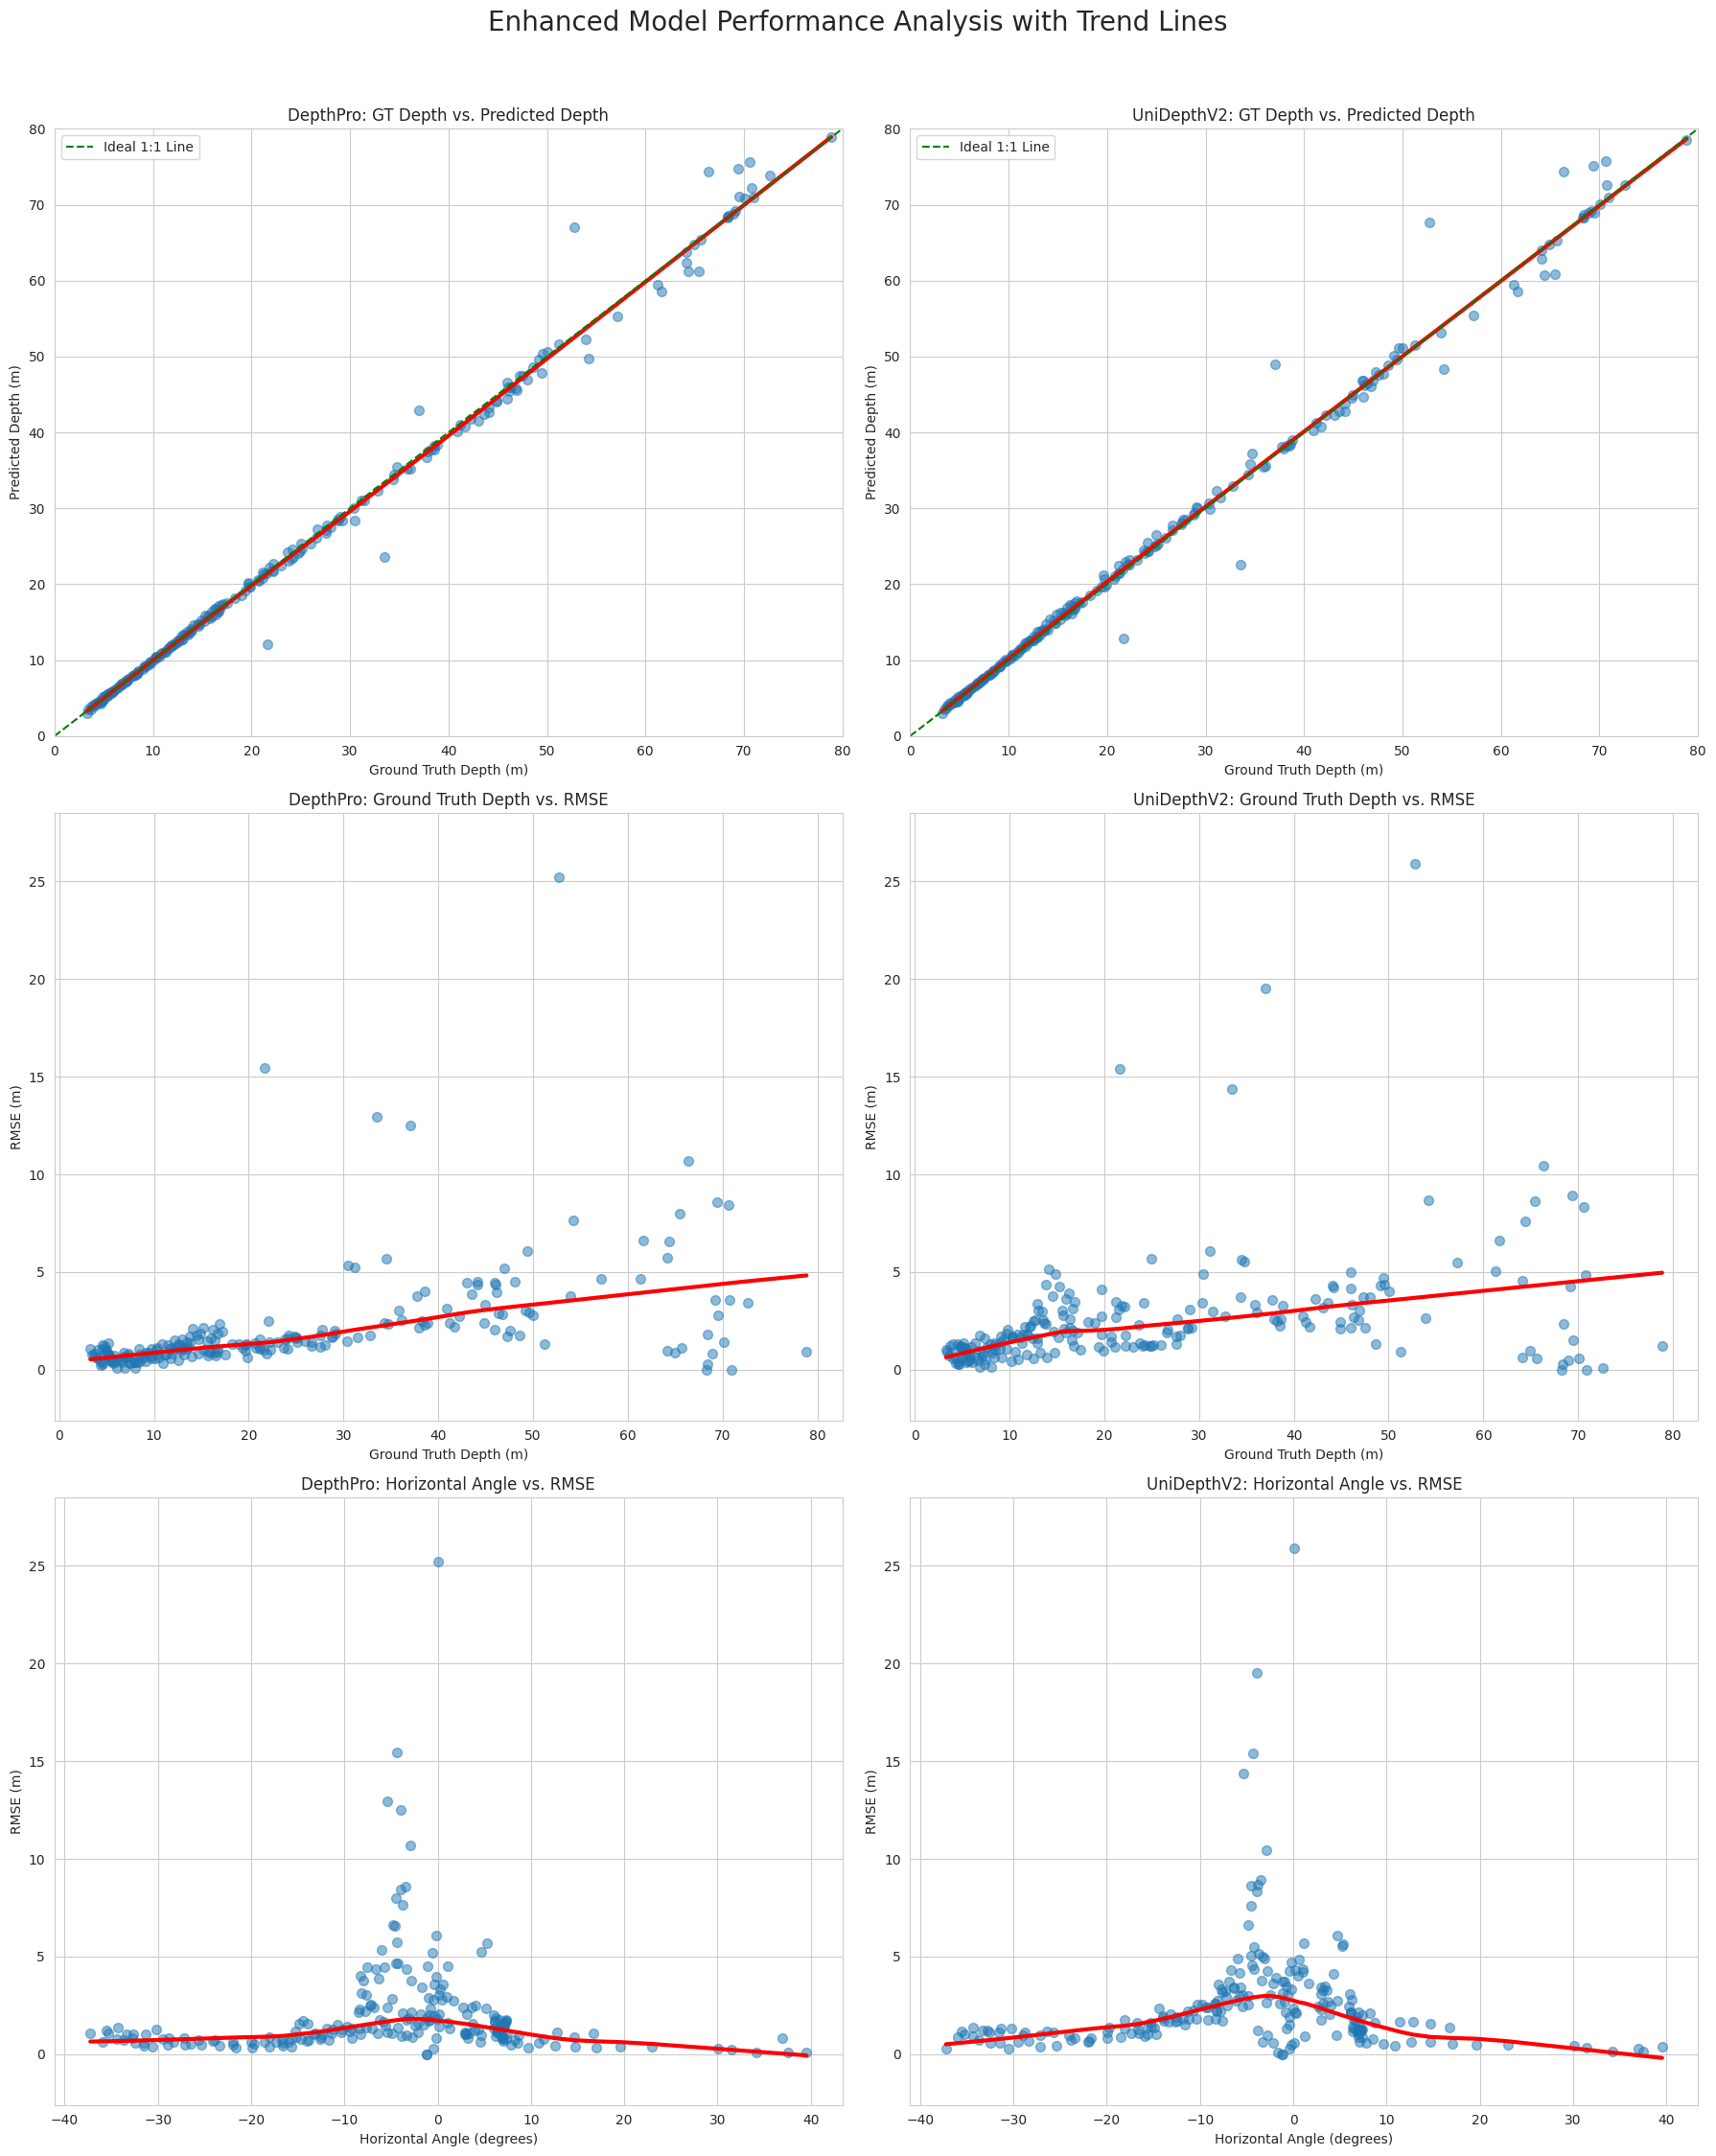

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
results_df = pd.read_csv('depth_evaluation_per_car_train.csv')

# Handle potential NaN values in the 'rmse' column
results_df.dropna(subset=['rmse'], inplace=True)


# Set plot style
sns.set_style("whitegrid")

# Separate dataframes for easier plotting
depthpro_df = results_df[results_df['model'] == 'DepthPro'].copy()
unidepth_df = results_df[results_df['model'] == 'UniDepthV2'].copy()

# --- Generate Enhanced 2D Scatter Plots ---
fig, axes = plt.subplots(3, 2, figsize=(18, 22))
fig.suptitle('Enhanced Model Performance Analysis with Trend Lines', fontsize=20, y=1.02)

# Scatter plot arguments
scatter_kws = {'s': 50, 'alpha': 0.5}
line_kws = {'color': 'red', 'linewidth': 3}

# --- Determine common y-axis limits for RMSE plots ---
min_rmse = results_df['rmse'].min()
max_rmse = results_df['rmse'].max()
rmse_buffer = (max_rmse - min_rmse) * 0.1 # 10% buffer
y_limits_rmse = (min_rmse - rmse_buffer, max_rmse + rmse_buffer)


# 1. GT Depth vs Predicted Depth (DepthPro)
sns.regplot(ax=axes[0, 0], data=depthpro_df, x='avg_gt_depth', y='avg_pred_depth',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[0, 0].set_title('DepthPro: GT Depth vs. Predicted Depth')
axes[0, 0].set_xlabel('Ground Truth Depth (m)')
axes[0, 0].set_ylabel('Predicted Depth (m)')
axes[0, 0].plot([0, 80], [0, 80], 'g--', label='Ideal 1:1 Line')
axes[0, 0].legend()
axes[0, 0].set(xlim=(0,80), ylim=(0,80))


# 2. GT Depth vs Predicted Depth (UniDepthV2)
sns.regplot(ax=axes[0, 1], data=unidepth_df, x='avg_gt_depth', y='avg_pred_depth',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[0, 1].set_title('UniDepthV2: GT Depth vs. Predicted Depth')
axes[0, 1].set_xlabel('Ground Truth Depth (m)')
axes[0, 1].set_ylabel('Predicted Depth (m)')
axes[0, 1].plot([0, 80], [0, 80], 'g--', label='Ideal 1:1 Line')
axes[0, 1].legend()
axes[0, 1].set(xlim=(0,80), ylim=(0,80))


# 3. GT Depth vs RMSE (DepthPro)
sns.regplot(ax=axes[1, 0], data=depthpro_df, x='avg_gt_depth', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[1, 0].set_title('DepthPro: Ground Truth Depth vs. RMSE')
axes[1, 0].set_xlabel('Ground Truth Depth (m)')
axes[1, 0].set_ylabel('RMSE (m)')
axes[1, 0].set_ylim(y_limits_rmse)

# 4. GT Depth vs RMSE (UniDepthV2)
sns.regplot(ax=axes[1, 1], data=unidepth_df, x='avg_gt_depth', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[1, 1].set_title('UniDepthV2: Ground Truth Depth vs. RMSE')
axes[1, 1].set_xlabel('Ground Truth Depth (m)')
axes[1, 1].set_ylabel('RMSE (m)')
axes[1, 1].set_ylim(y_limits_rmse)

# 5. Horizontal Angle vs RMSE (DepthPro)
sns.regplot(ax=axes[2, 0], data=depthpro_df, x='horizontal_angle', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[2, 0].set_title('DepthPro: Horizontal Angle vs. RMSE')
axes[2, 0].set_xlabel('Horizontal Angle (degrees)')
axes[2, 0].set_ylabel('RMSE (m)')
axes[2, 0].set_ylim(y_limits_rmse)

# 6. Horizontal Angle vs RMSE (UniDepthV2)
sns.regplot(ax=axes[2, 1], data=unidepth_df, x='horizontal_angle', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[2, 1].set_title('UniDepthV2: Horizontal Angle vs. RMSE')
axes[2, 1].set_xlabel('Horizontal Angle (degrees)')
axes[2, 1].set_ylabel('RMSE (m)')
axes[2, 1].set_ylim(y_limits_rmse)

plt.tight_layout()
plt.show()

/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


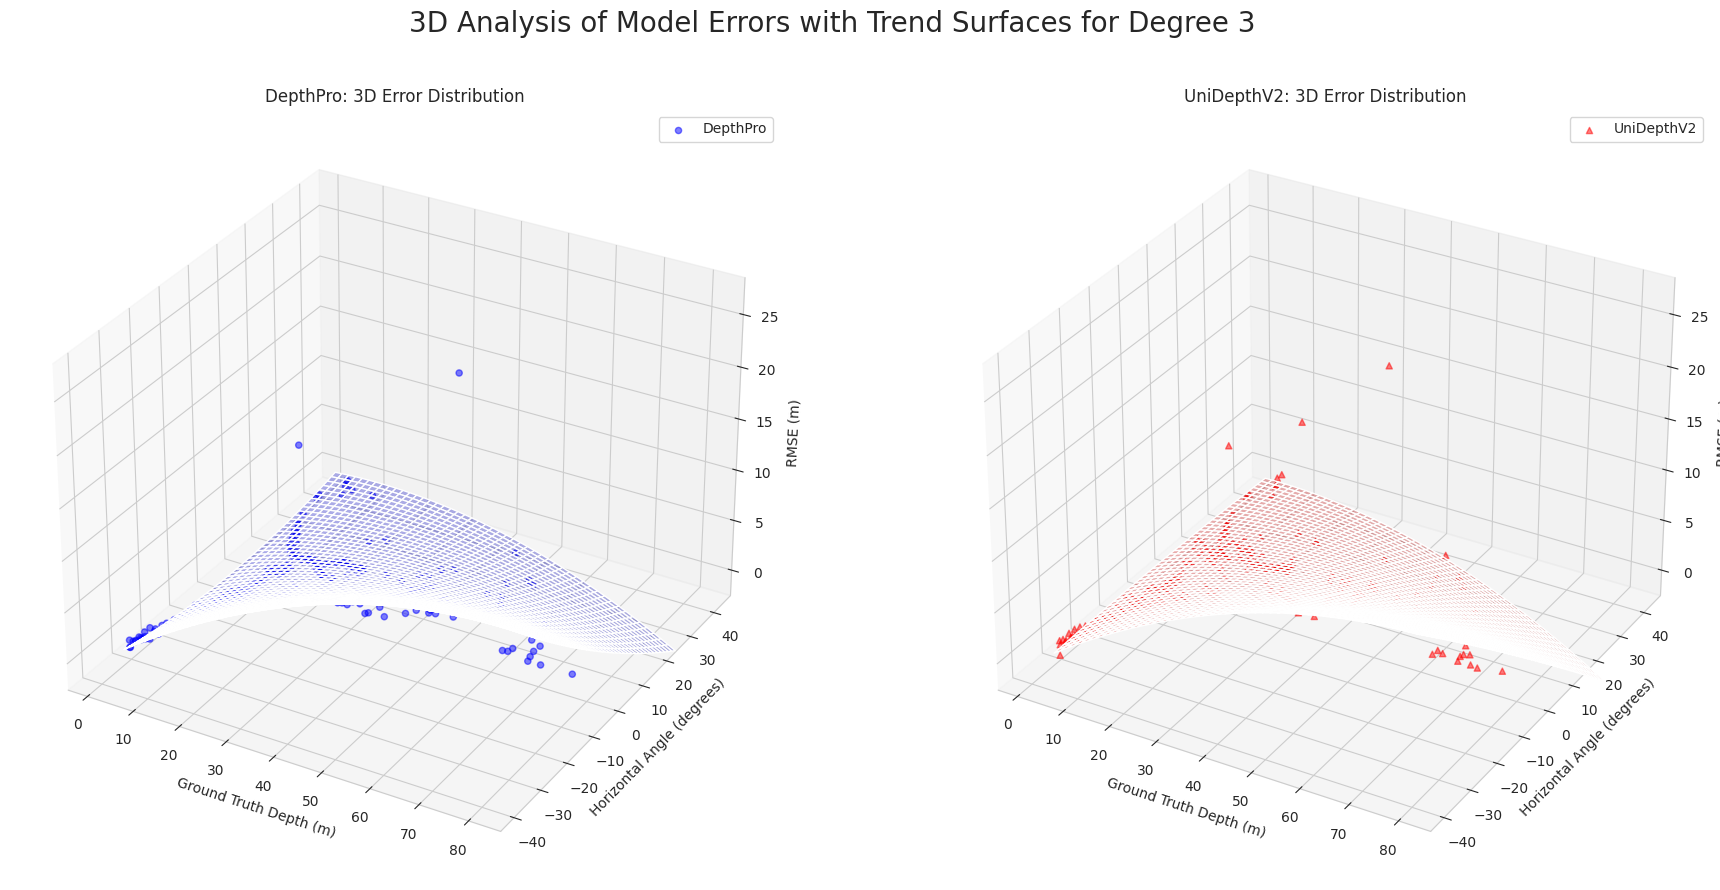

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Load the data from the CSV file
results_df = pd.read_csv('depth_evaluation_per_car_train.csv')

# Separate dataframes for each model
depthpro_df = results_df[results_df['model'] == 'DepthPro'].copy()
unidepth_df = results_df[results_df['model'] == 'UniDepthV2'].copy()

# --- Handle potential NaN values by creating cleaned dataframes ---
depthpro_df_cleaned = depthpro_df.dropna(subset=['avg_gt_depth', 'horizontal_angle', 'rmse'])
unidepth_df_cleaned = unidepth_df.dropna(subset=['avg_gt_depth', 'horizontal_angle', 'rmse'])
results_df_cleaned = pd.concat([depthpro_df_cleaned, unidepth_df_cleaned])

# --- Determine common axis limits for 3D plots from cleaned data ---
x_min, x_max = results_df_cleaned['avg_gt_depth'].min(), results_df_cleaned['avg_gt_depth'].max()
y_min, y_max = results_df_cleaned['horizontal_angle'].min(), results_df_cleaned['horizontal_angle'].max()
z_min, z_max = results_df_cleaned['rmse'].min(), results_df_cleaned['rmse'].max()

# Add some buffer for better visualization
x_buffer = (x_max - x_min) * 0.1
y_buffer = (y_max - y_min) * 0.1
z_buffer = (z_max - z_min) * 0.1

fig = plt.figure(figsize=(22, 10))
fig.suptitle('3D Analysis of Model Errors with Trend Surfaces for Degree 3', fontsize=20)

# --- Plot for DepthPro ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(depthpro_df_cleaned['avg_gt_depth'], depthpro_df_cleaned['horizontal_angle'], depthpro_df_cleaned['rmse'], c='b', marker='o', label='DepthPro', alpha=0.5)

# Fit a Polynomial Regression model to create a curved surface
X1 = depthpro_df_cleaned[['avg_gt_depth', 'horizontal_angle']]
y1 = depthpro_df_cleaned['rmse']

# Define the degree of the polynomial. 
# A degree of 2 creates a quadratic surface (a simple curve).
# You can experiment with a degree of 3 for a more complex curve.
degree = 2
model1_curved = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model1_curved.fit(X1, y1)

# Create a denser meshgrid for a smoother surface plot
# We increase the number of points from 20 to 50 for better visual quality.
x_surf1, y_surf1 = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

# Predict z values on the meshgrid using the polynomial model.
# This will generate the heights for our curved surface.
z_surf1 = model1_curved.predict(np.c_[x_surf1.ravel(), y_surf1.ravel()]).reshape(x_surf1.shape)

# Plot the curved trend surface
# This command remains the same, but it will now plot a curve thanks to the new z_surf2 values.
ax1.plot_surface(x_surf1, y_surf1, z_surf1, color='blue', alpha=0.3, rstride=1, cstride=1)


ax1.set_xlabel('Ground Truth Depth (m)')
ax1.set_ylabel('Horizontal Angle (degrees)')
ax1.set_zlabel('RMSE (m)')
ax1.set_title('DepthPro: 3D Error Distribution')
ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
ax1.set_ylim(y_min - y_buffer, y_max + y_buffer)
ax1.set_zlim(z_min - z_buffer, z_max + z_buffer)
ax1.legend()


# --- Plot for UniDepthV2 ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(unidepth_df_cleaned['avg_gt_depth'], unidepth_df_cleaned['horizontal_angle'], unidepth_df_cleaned['rmse'], c='r', marker='^', label='UniDepthV2', alpha=0.5)

# Fit a Polynomial Regression model to create a curved surface
X2 = unidepth_df_cleaned[['avg_gt_depth', 'horizontal_angle']]
y2 = unidepth_df_cleaned['rmse']

# Define the degree of the polynomial. 
# A degree of 2 creates a quadratic surface (a simple curve).
model2_curved = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model2_curved.fit(X2, y2)

# Create a denser meshgrid for a smoother surface plot
# We increase the number of points from 20 to 50 for better visual quality.
x_surf2, y_surf2 = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

# Predict z values on the meshgrid using the polynomial model.
# This will generate the heights for our curved surface.
z_surf2 = model2_curved.predict(np.c_[x_surf2.ravel(), y_surf2.ravel()]).reshape(x_surf2.shape)

# Plot the curved trend surface
# This command remains the same, but it will now plot a curve thanks to the new z_surf2 values.
ax2.plot_surface(x_surf2, y_surf2, z_surf2, color='red', alpha=0.3, rstride=1, cstride=1)


ax2.set_xlabel('Ground Truth Depth (m)')
ax2.set_ylabel('Horizontal Angle (degrees)')
ax2.set_zlabel('RMSE (m)')
ax2.set_title('UniDepthV2: 3D Error Distribution')
ax2.set_xlim(x_min - x_buffer, x_max + x_buffer)
ax2.set_ylim(y_min - y_buffer, y_max + y_buffer)
ax2.set_zlim(z_min - z_buffer, z_max + z_buffer)
ax2.legend()


plt.show()

In [ ]:
# Path Discovery for Nested KITTI Eigen Dataset

# Path to your dataset root
root_path = r"/mnt/c/Users/arkad/OneDrive/Desktop/Thesis work/kitti eigen split dataset"
test_root = os.path.join(root_path, "train_copy")

min_depth = 1e-3
max_depth = 80.0

# Recursively find all ground-truth depth files
gt_pngs = glob.glob(os.path.join(test_root, "*", "*_sync", "proj_depth", "groundtruth", "image_02", "*.png"))

rel_list = []
for gt_path in tqdm(gt_pngs, desc="Indexing depth files"):
    # Extract components from full path
    parts = gt_path.split(os.path.sep)
    date = parts[-6]                 # e.g., '2011_09_26'
    drive = parts[-5]                # e.g., '2011_09_26_drive_0002_sync'
    filename = parts[-1]            # e.g., '0000000005.png'

    # Construct RGB path
    rgb_path = os.path.join(test_root, date, drive, "image_02", "data", filename)
    if not os.path.exists(rgb_path):
        print(f"Missing RGB image: {rgb_path}")
        continue

    rel_list.append({
        "sequence": date,
        "drive": drive,
        "filename": filename,
        "gt_path": gt_path,
        "rgb_path": rgb_path
    })

val_list = pd.DataFrame(rel_list)
print(f"Found {len(val_list)} image pairs from {val_list['drive'].nunique()} drives across {val_list['sequence'].nunique()} sequences.")


Indexing depth files:   0%|          | 0/500 [00:00<?, ?it/s]

Found 500 image pairs from 1 drives across 1 sequences.


In [ ]:
# Import OpenCV for video processing. If you don't have it installed, run: pip install opencv-python
import cv2
import numpy as np # Make sure numpy is imported

def extract_and_process_frames(video_path, invert_depth=False):
    """
    Extracts all frames from a video file, converts them to grayscale,
    and optionally inverts the depth values.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames
        
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        
        # Invert the depth values if specified (white -> black, black -> white)
        # This is needed for the inverted metric depth video
        if invert_depth:
            # Convert frame to grayscale as depth maps are single-channel
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            processed_frame = 255 - (gray_frame)
            #processed_frame = 1 / ((gray_frame / 256.0) + 1e-6)
        else:
            # Convert frame to grayscale as depth maps are single-channel
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            processed_frame = gray_frame
            
        frames.append(processed_frame)
        
    cap.release()
    return frames

# Paths to the video files
metric_video_path = "/mnt/c/Users/arkad/OneDrive/Desktop/Thesis work/kitti eigen split dataset/kitti_videos/2011_09_30_drive_0028_vis.mp4"
relative_video_path = "/mnt/c/Users/arkad/OneDrive/Desktop/Thesis work/kitti eigen split dataset/kitti_videos/100_results/2011_09_30_drive_0028_vis.mp4"

# --- Extract and Process Frames ---
# For the metric video, we set invert_depth=True to correct the inverted output.
print("Extracting and processing frames from metric depth video (inverting depth)...")
metric_depth_frames = extract_and_process_frames(metric_video_path, invert_depth=True)
print(f"Extracted {len(metric_depth_frames)} frames from the metric depth video.")

# For the relative video, we process it as a standard grayscale video.
print("\nExtracting and processing frames from relative depth video...")
relative_depth_frames = extract_and_process_frames(relative_video_path, invert_depth=False)
print(f"Extracted {len(relative_depth_frames)} frames from the relative depth video.")

Extracting and processing frames from metric depth video (inverting depth)...
Extracted 500 frames from the metric depth video.

Extracting and processing frames from relative depth video...
Extracted 500 frames from the relative depth video.


In [ ]:
# This list will store a dictionary for each detected vehicle for the new models.

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import math

all_results_data_video = []
FOCAL_LENGTH_X = 721.5577
# --- Main Processing Loop for Video Depth Models ---
# We use val_list from your original notebook which contains the paths to the ground truth data
skip_frames = 0; # Number of frames to skip
for index, row in tqdm(val_list.iterrows(), total=len(val_list), desc="Processing Video Frames"):
    if index >= len(metric_depth_frames) or index >= len(relative_depth_frames):
        print(f"Skipping index {index} as it is out of bounds for the video frames.")
        continue

    filename = row['filename']
    image_path = row['rgb_path']
    gt_path = row['gt_path']

    try:
        image_np = np.array(Image.open(image_path).convert("RGB"))
        gt_depth = np.array(Image.open(gt_path)).astype(np.uint16) / 256.0

        # Get image dimensions for angle calculation
        img_height, img_width, _ = image_np.shape
        principal_point_x = img_width / 2

        # Get the predicted depth from the extracted video frames
        pred_depth_metric = metric_depth_frames[index + skip_frames]
        pred_depth_relative = relative_depth_frames[index + skip_frames]

        # Get vehicle masks
        car_masks_info = individual_vehicle_segmentation(image_np)

        if not car_masks_info:
            continue

        # Process each detected car in the image
        for i, car_info in enumerate(car_masks_info):
            mask = car_info['mask']
            score = car_info['score']
            
            if score < 0.9:
                continue

            crop_mask = eigen_crop_mask(gt_depth.shape)
            final_mask = mask & (gt_depth > min_depth) & (gt_depth < max_depth) & crop_mask

            if not np.any(final_mask):
                continue
                
            # --- Evaluate Metric Depth Video ---
            # The metric depth is already in the correct scale, so no median scaling is applied
            #pred_depth_metric_clipped = np.clip(pred_depth_metric, min_depth, max_depth)
            #pred_depth_metric_clipped = pred_depth_metric
            #scale_metric = np.median(gt_depth[final_mask]) / np.median(pred_depth_metric_clipped[final_mask])
            #pred_depth_metric_scaled = np.clip(pred_depth_metric_clipped * scale_metric, min_depth, max_depth)
            #metrics_metric = compute_depth_errors(gt_depth, pred_depth_metric_scaled, final_mask)

            median_pred_metric = np.median(pred_depth_metric[final_mask])
            scale_metric = np.median(gt_depth[final_mask]) / (median_pred_metric + 1e-6)
            pred_depth_metric_scaled = np.clip(pred_depth_metric * scale_metric, min_depth, max_depth)
            metrics_metric = compute_depth_errors(gt_depth, pred_depth_metric_scaled, final_mask)

            # Calculate horizontal angle
            y_coords, x_coords = np.where(mask)
            centroid_x = np.mean(x_coords)
            angle_rad = math.atan((centroid_x - principal_point_x) / FOCAL_LENGTH_X)
            angle_deg = math.degrees(angle_rad)

            # Store results for the metric depth video
            all_results_data_video.append({
                'model': 'VideoDepth_Metric',
                'file_name': filename,
                'car_id': i,
                'car_score': score,
                'avg_gt_depth': np.mean(gt_depth[final_mask]),
                'avg_pred_depth': np.mean(pred_depth_metric_scaled[final_mask]),
                'rmse': metrics_metric['rmse'],
                'horizontal_angle': angle_deg
            })

            # --- Evaluate Relative Depth Video ---
            # Apply median scaling for the relative depth video
            pred_depth_relative_clipped = np.clip(pred_depth_relative, min_depth, max_depth)
            scale_relative = np.median(gt_depth[final_mask]) / np.median(pred_depth_relative_clipped[final_mask])
            pred_depth_relative_scaled = np.clip(pred_depth_relative_clipped * scale_relative, min_depth, max_depth)
            metrics_relative = compute_depth_errors(gt_depth, pred_depth_relative_scaled, final_mask)
            
            # Store results for the relative depth video
            all_results_data_video.append({
                'model': 'VideoDepth_Relative',
                'file_name': filename,
                'car_id': i,
                'car_score': score,
                'avg_gt_depth': np.mean(gt_depth[final_mask]),
                'avg_pred_depth': np.mean(pred_depth_relative_scaled[final_mask]),
                'rmse': metrics_relative['rmse'],
                'horizontal_angle': angle_deg
            })

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Create a new DataFrame for the video model results
results_df_video = pd.DataFrame(all_results_data_video)

print("\nData processing for video models complete. DataFrame created.")

Processing Video Frames:   0%|          | 0/500 [00:00<?, ?it/s]


Data processing for video models complete. DataFrame created.


In [ ]:
# Display the results
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1600)  # Set a wider display width for better readability
print(results_df_video)

# Save the results to a CSV file
output_csv_path_video = "depth_evaluation_video_models.csv"
results_df_video.to_csv(output_csv_path_video, index=False)

print(f"\nResults for video models saved to {output_csv_path_video}")

                    model       file_name  car_id  car_score  avg_gt_depth  avg_pred_depth      rmse  horizontal_angle
0       VideoDepth_Metric  0000000005.png       0   0.992322     13.609392       12.787788  2.452483         -9.389326
1     VideoDepth_Relative  0000000005.png       0   0.992322     13.609392       11.916579  4.027181         -9.389326
2       VideoDepth_Metric  0000000005.png       1   0.908172     29.055697       28.295855  3.766325          6.023349
3     VideoDepth_Relative  0000000005.png       1   0.908172     29.055697       28.216423  5.773238          6.023349
4       VideoDepth_Metric  0000000005.png       3   0.967079     17.188039       17.020894  2.072126         -0.372849
...                   ...             ...     ...        ...           ...             ...       ...               ...
3387  VideoDepth_Relative  0000000500.png       2   0.978777     16.966815       15.940857  2.033974         38.110877
3388    VideoDepth_Metric  0000000501.png       

In [ ]:
# --- Calculate and Print Average RMSE per Model ---

# Group by model, calculate the mean RMSE, and convert to a DataFrame
average_rmse_df = results_df_video.groupby('model')['rmse'].mean().reset_index()

# Rename columns for clarity
average_rmse_df.columns = ['Model', 'Avg RMSE (m)']


print("Average RMSE per Model:")
print("-" * 35)
# Print the DataFrame using to_string() for clean formatting without the index
print(average_rmse_df.to_string(index=False))
print("-" * 35)

Average RMSE per Model:
-----------------------------------
              Model  Avg RMSE (m)
  VideoDepth_Metric      2.606930
VideoDepth_Relative      5.368384
-----------------------------------


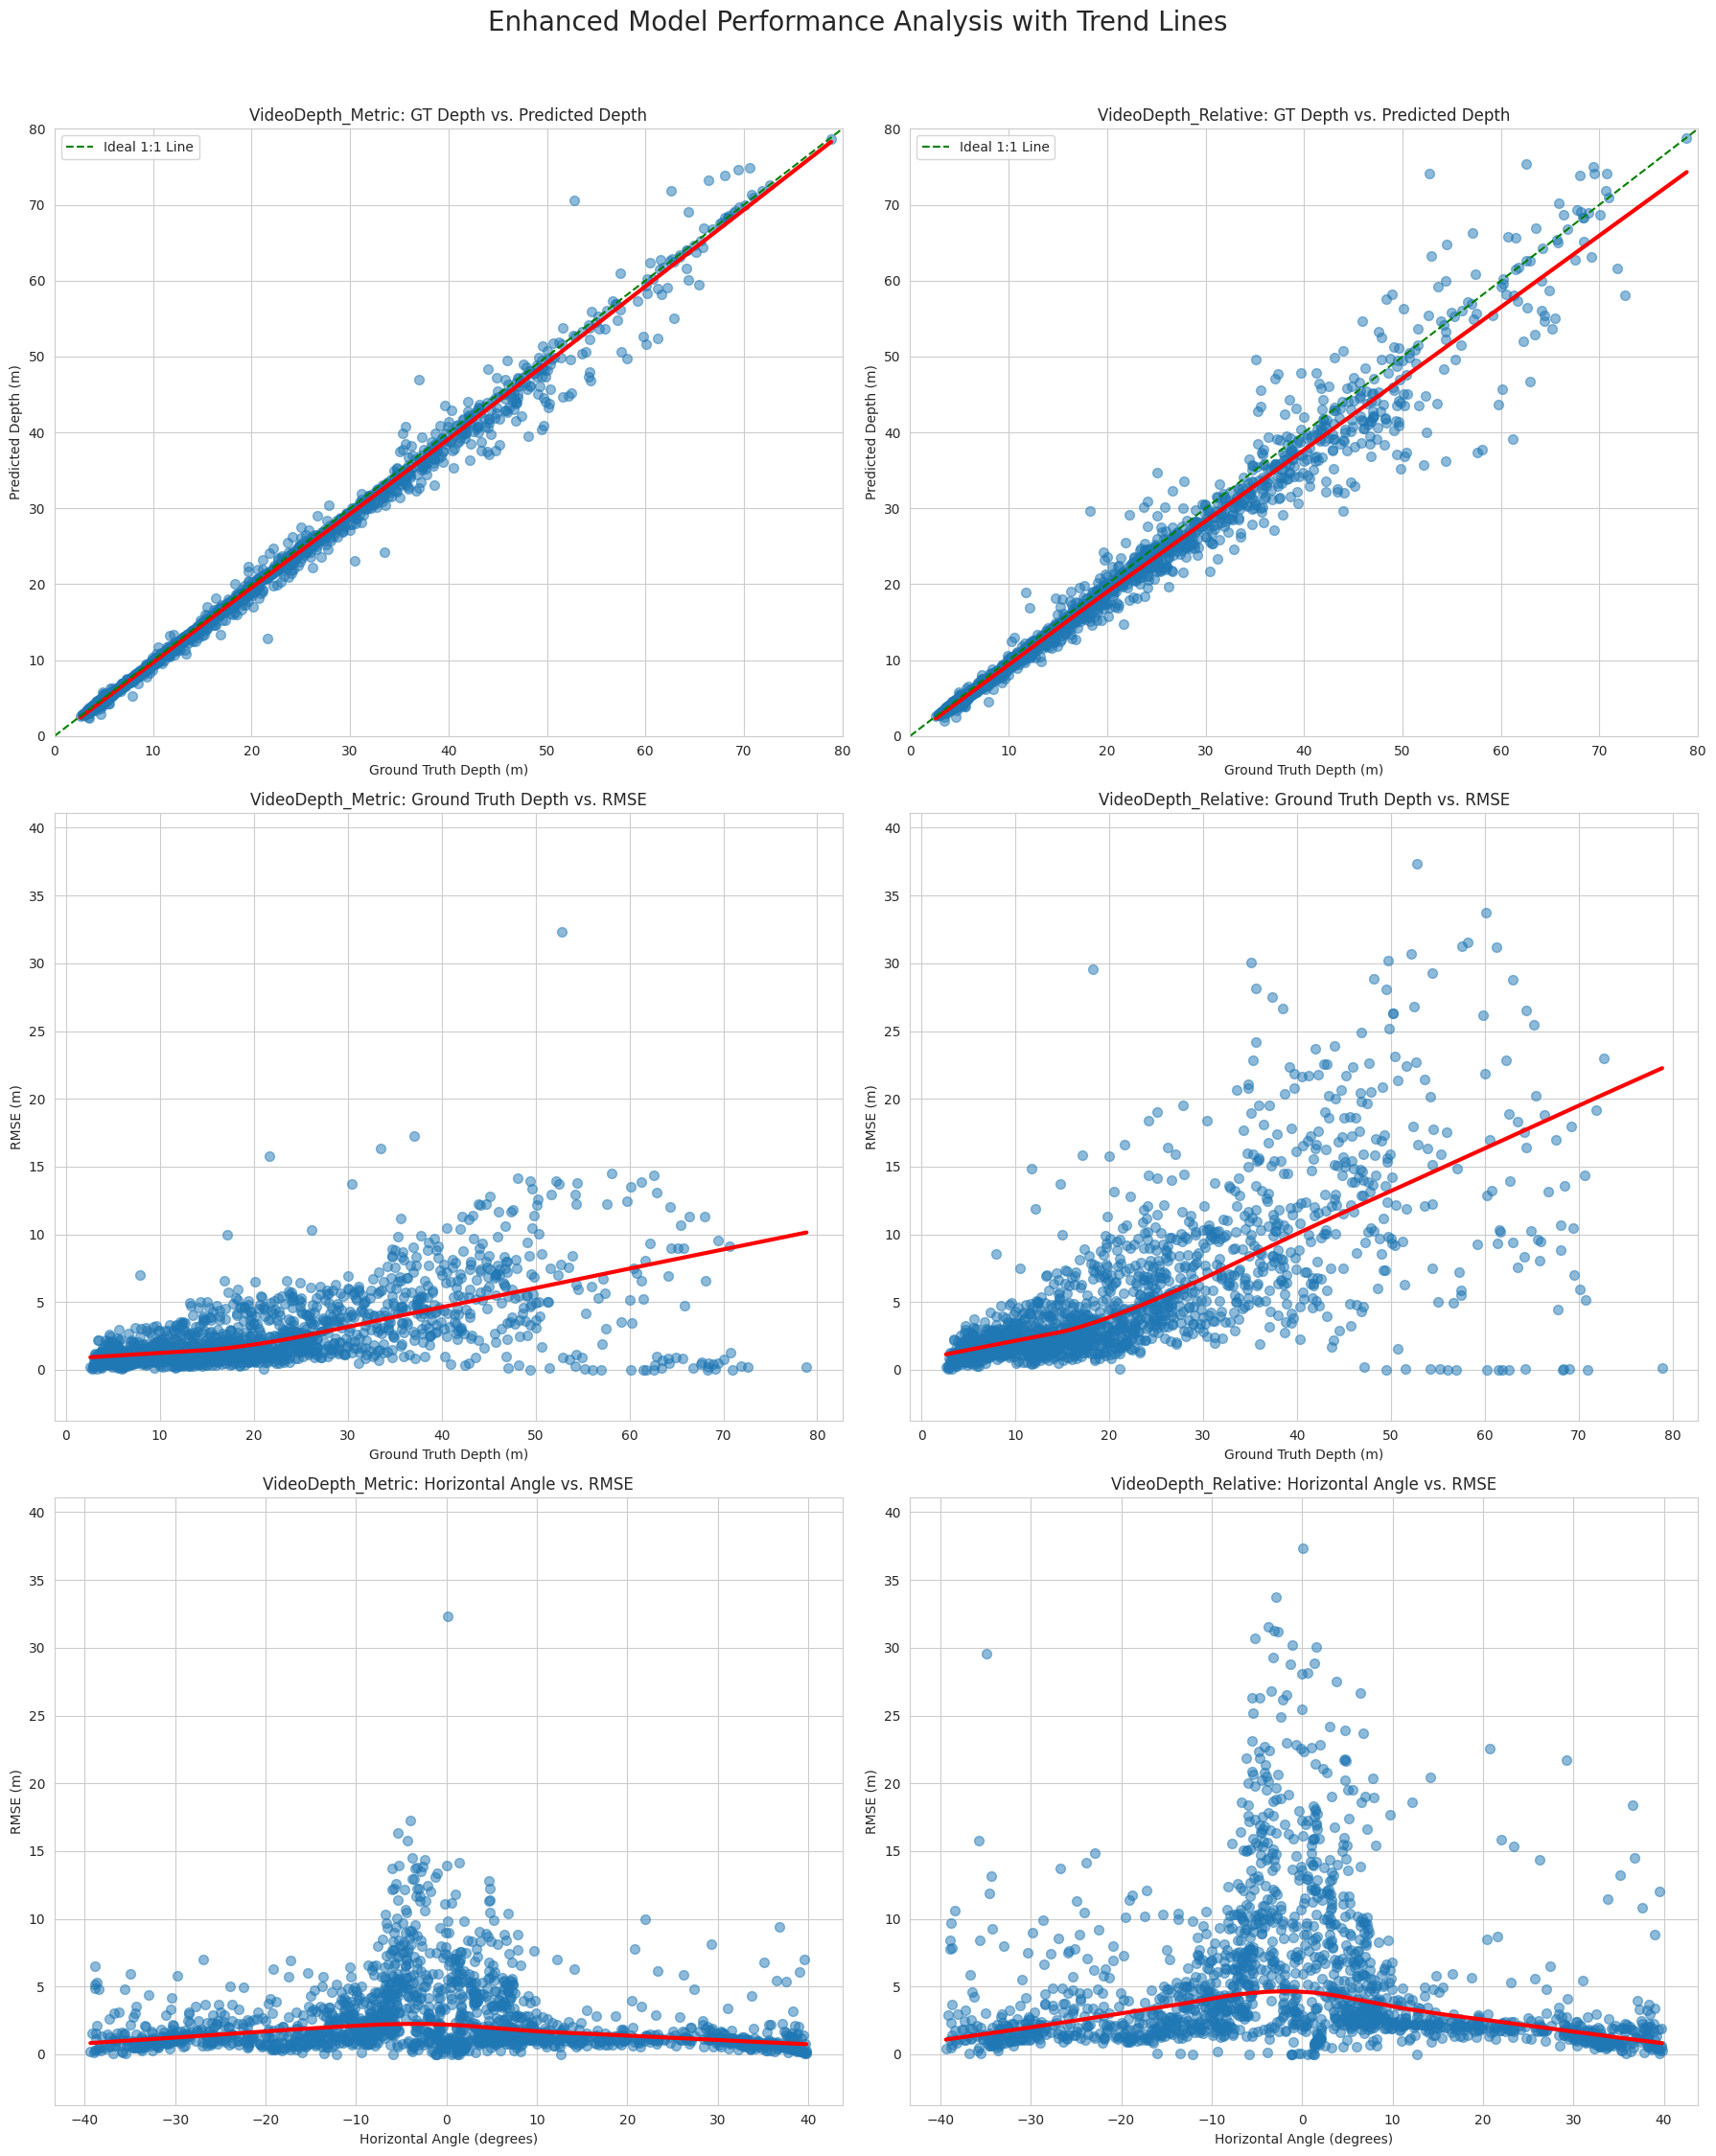

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file
results_df = pd.read_csv("depth_evaluation_video_models.csv")

# Handle potential NaN values in the 'rmse' column
results_df.dropna(subset=['rmse'], inplace=True)


# Set plot style
sns.set_style("whitegrid")

# Separate dataframes for easier plotting
depthpro_df = results_df[results_df['model'] == 'VideoDepth_Metric'].copy()
unidepth_df = results_df[results_df['model'] == 'VideoDepth_Relative'].copy()

# --- Generate Enhanced 2D Scatter Plots ---
fig, axes = plt.subplots(3, 2, figsize=(18, 22))
fig.suptitle('Enhanced Model Performance Analysis with Trend Lines', fontsize=20, y=1.02)

# Scatter plot arguments
scatter_kws = {'s': 50, 'alpha': 0.5}
line_kws = {'color': 'red', 'linewidth': 3}

# --- Determine common y-axis limits for RMSE plots ---
min_rmse = results_df['rmse'].min()
max_rmse = results_df['rmse'].max()
rmse_buffer = (max_rmse - min_rmse) * 0.1 # 10% buffer
y_limits_rmse = (min_rmse - rmse_buffer, max_rmse + rmse_buffer)


# 1. GT Depth vs Predicted Depth (DepthPro)
sns.regplot(ax=axes[0, 0], data=depthpro_df, x='avg_gt_depth', y='avg_pred_depth',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[0, 0].set_title('VideoDepth_Metric: GT Depth vs. Predicted Depth')
axes[0, 0].set_xlabel('Ground Truth Depth (m)')
axes[0, 0].set_ylabel('Predicted Depth (m)')
axes[0, 0].plot([0, 80], [0, 80], 'g--', label='Ideal 1:1 Line')
axes[0, 0].legend()
axes[0, 0].set(xlim=(0,80), ylim=(0,80))


# 2. GT Depth vs Predicted Depth (UniDepthV2)
sns.regplot(ax=axes[0, 1], data=unidepth_df, x='avg_gt_depth', y='avg_pred_depth',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[0, 1].set_title('VideoDepth_Relative: GT Depth vs. Predicted Depth')
axes[0, 1].set_xlabel('Ground Truth Depth (m)')
axes[0, 1].set_ylabel('Predicted Depth (m)')
axes[0, 1].plot([0, 80], [0, 80], 'g--', label='Ideal 1:1 Line')
axes[0, 1].legend()
axes[0, 1].set(xlim=(0,80), ylim=(0,80))


# 3. GT Depth vs RMSE (DepthPro)
sns.regplot(ax=axes[1, 0], data=depthpro_df, x='avg_gt_depth', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[1, 0].set_title('VideoDepth_Metric: Ground Truth Depth vs. RMSE')
axes[1, 0].set_xlabel('Ground Truth Depth (m)')
axes[1, 0].set_ylabel('RMSE (m)')
axes[1, 0].set_ylim(y_limits_rmse)

# 4. GT Depth vs RMSE (UniDepthV2)
sns.regplot(ax=axes[1, 1], data=unidepth_df, x='avg_gt_depth', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[1, 1].set_title('VideoDepth_Relative: Ground Truth Depth vs. RMSE')
axes[1, 1].set_xlabel('Ground Truth Depth (m)')
axes[1, 1].set_ylabel('RMSE (m)')
axes[1, 1].set_ylim(y_limits_rmse)

# 5. Horizontal Angle vs RMSE (DepthPro)
sns.regplot(ax=axes[2, 0], data=depthpro_df, x='horizontal_angle', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[2, 0].set_title('VideoDepth_Metric: Horizontal Angle vs. RMSE')
axes[2, 0].set_xlabel('Horizontal Angle (degrees)')
axes[2, 0].set_ylabel('RMSE (m)')
axes[2, 0].set_ylim(y_limits_rmse)

# 6. Horizontal Angle vs RMSE (UniDepthV2)
sns.regplot(ax=axes[2, 1], data=unidepth_df, x='horizontal_angle', y='rmse',
            scatter_kws=scatter_kws, line_kws=line_kws, lowess=True)
axes[2, 1].set_title('VideoDepth_Relative: Horizontal Angle vs. RMSE')
axes[2, 1].set_xlabel('Horizontal Angle (degrees)')
axes[2, 1].set_ylabel('RMSE (m)')
axes[2, 1].set_ylim(y_limits_rmse)

plt.tight_layout()
plt.show()

/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/arkadiptasarkar/MDE_project_wsl/env_4_mde/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


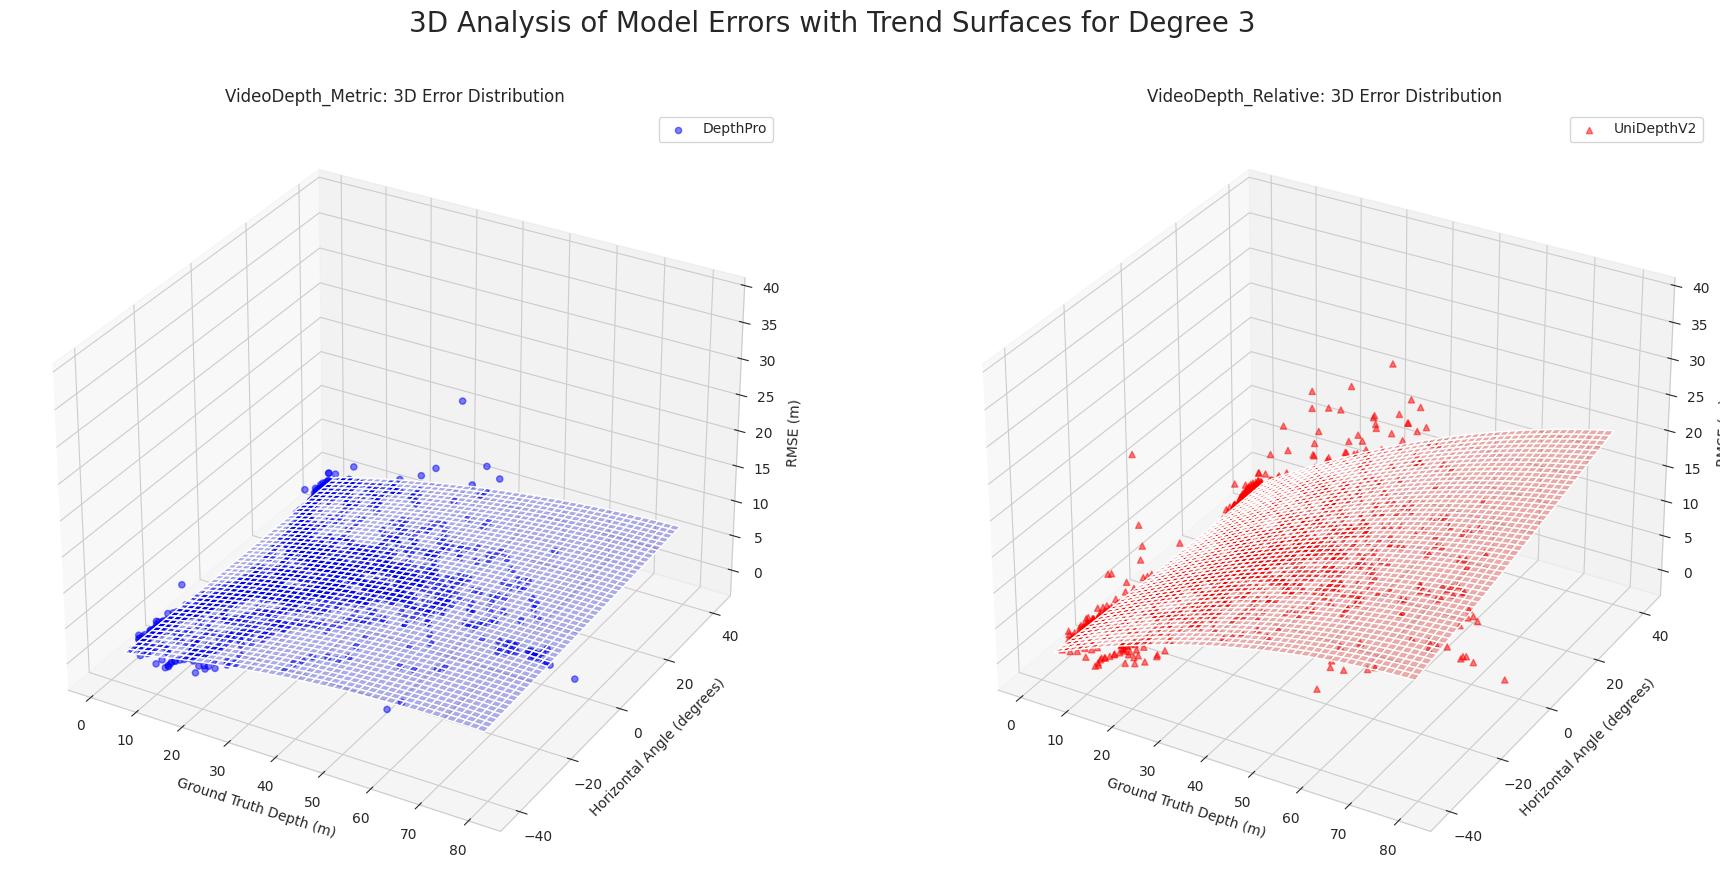

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Load the data from the CSV file
results_df = pd.read_csv("depth_evaluation_video_models.csv")

# Separate dataframes for each model
depthpro_df = results_df[results_df['model'] == 'VideoDepth_Metric'].copy()
unidepth_df = results_df[results_df['model'] == 'VideoDepth_Relative'].copy()

# --- Handle potential NaN values by creating cleaned dataframes ---
depthpro_df_cleaned = depthpro_df.dropna(subset=['avg_gt_depth', 'horizontal_angle', 'rmse'])
unidepth_df_cleaned = unidepth_df.dropna(subset=['avg_gt_depth', 'horizontal_angle', 'rmse'])
results_df_cleaned = pd.concat([depthpro_df_cleaned, unidepth_df_cleaned])

# --- Determine common axis limits for 3D plots from cleaned data ---
x_min, x_max = results_df_cleaned['avg_gt_depth'].min(), results_df_cleaned['avg_gt_depth'].max()
y_min, y_max = results_df_cleaned['horizontal_angle'].min(), results_df_cleaned['horizontal_angle'].max()
z_min, z_max = results_df_cleaned['rmse'].min(), results_df_cleaned['rmse'].max()

# Add some buffer for better visualization
x_buffer = (x_max - x_min) * 0.1
y_buffer = (y_max - y_min) * 0.1
z_buffer = (z_max - z_min) * 0.1

fig = plt.figure(figsize=(22, 10))
fig.suptitle('3D Analysis of Model Errors with Trend Surfaces for Degree 3', fontsize=20)

# --- Plot for DepthPro ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(depthpro_df_cleaned['avg_gt_depth'], depthpro_df_cleaned['horizontal_angle'], depthpro_df_cleaned['rmse'], c='b', marker='o', label='DepthPro', alpha=0.5)

# Fit a Polynomial Regression model to create a curved surface
X1 = depthpro_df_cleaned[['avg_gt_depth', 'horizontal_angle']]
y1 = depthpro_df_cleaned['rmse']

# Define the degree of the polynomial. 
# A degree of 2 creates a quadratic surface (a simple curve).
# You can experiment with a degree of 3 for a more complex curve.
degree = 2
model1_curved = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model1_curved.fit(X1, y1)

# Create a denser meshgrid for a smoother surface plot
# We increase the number of points from 20 to 50 for better visual quality.
x_surf1, y_surf1 = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

# Predict z values on the meshgrid using the polynomial model.
# This will generate the heights for our curved surface.
z_surf1 = model1_curved.predict(np.c_[x_surf1.ravel(), y_surf1.ravel()]).reshape(x_surf1.shape)

# Plot the curved trend surface
# This command remains the same, but it will now plot a curve thanks to the new z_surf2 values.
ax1.plot_surface(x_surf1, y_surf1, z_surf1, color='blue', alpha=0.3, rstride=1, cstride=1)


ax1.set_xlabel('Ground Truth Depth (m)')
ax1.set_ylabel('Horizontal Angle (degrees)')
ax1.set_zlabel('RMSE (m)')
ax1.set_title('VideoDepth_Metric: 3D Error Distribution')
ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
ax1.set_ylim(y_min - y_buffer, y_max + y_buffer)
ax1.set_zlim(z_min - z_buffer, z_max + z_buffer)
ax1.legend()


# --- Plot for UniDepthV2 ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(unidepth_df_cleaned['avg_gt_depth'], unidepth_df_cleaned['horizontal_angle'], unidepth_df_cleaned['rmse'], c='r', marker='^', label='UniDepthV2', alpha=0.5)

# Fit a Polynomial Regression model to create a curved surface
X2 = unidepth_df_cleaned[['avg_gt_depth', 'horizontal_angle']]
y2 = unidepth_df_cleaned['rmse']

# Define the degree of the polynomial. 
# A degree of 2 creates a quadratic surface (a simple curve).
model2_curved = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model2_curved.fit(X2, y2)

# Create a denser meshgrid for a smoother surface plot
# We increase the number of points from 20 to 50 for better visual quality.
x_surf2, y_surf2 = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

# Predict z values on the meshgrid using the polynomial model.
# This will generate the heights for our curved surface.
z_surf2 = model2_curved.predict(np.c_[x_surf2.ravel(), y_surf2.ravel()]).reshape(x_surf2.shape)

# Plot the curved trend surface
# This command remains the same, but it will now plot a curve thanks to the new z_surf2 values.
ax2.plot_surface(x_surf2, y_surf2, z_surf2, color='red', alpha=0.3, rstride=1, cstride=1)


ax2.set_xlabel('Ground Truth Depth (m)')
ax2.set_ylabel('Horizontal Angle (degrees)')
ax2.set_zlabel('RMSE (m)')
ax2.set_title('VideoDepth_Relative: 3D Error Distribution')
ax2.set_xlim(x_min - x_buffer, x_max + x_buffer)
ax2.set_ylim(y_min - y_buffer, y_max + y_buffer)
ax2.set_zlim(z_min - z_buffer, z_max + z_buffer)
ax2.legend()


plt.show()